# Prediction

## Load preprocessed dataframes

In [31]:
from utils import *

train_df = pd.read_pickle("../out/train.pkl")
test_df = pd.read_pickle("../out/test.pkl")

RANDOM_STATE=42

## Columns to drop and feature target

In [32]:
columns_to_drop = ["loan_id", "status"]
target_column = "status"

train_df.drop(columns_to_drop, axis=1).head()

,loan_amount,payments,issuance_frequency_per_month,no. of municipalities with inhabitants < 499,no. of cities,region_woe,balance_mean,balance_min,client_count_mean,operation_count,type_transaction_count_withdrawal,balance_dropped_below_zero,account_age,days_since_last_transaction
0,80952,3373,1.000000,0,1,-0.618649,32590.624074,1100.0,2.0,44,32,False,313,5
1,30276,2523,1.000000,87,7,-0.502458,25197.092500,715.0,1.0,56,34,False,388,19
2,165960,6915,1.000000,74,8,-0.502458,52523.244800,700.0,1.0,107,88,False,561,2
3,88440,7370,13.044643,9,8,2.938585,62778.090323,200.0,2.0,25,15,False,179,6
4,104808,8734,1.000000,151,5,0.334202,38709.830000,500.0,2.0,25,18,False,186,6


## Tune Models

### Decision Tree

In [33]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

parameter_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': range(1, 7)
}

dt, dt_fs, dt_os, dt_fs_os = (tune_model(
    train_df, 
    DecisionTreeClassifier(random_state=RANDOM_STATE),
    parameter_grid, 
    columns_to_drop, 
    target_column,
    oversample=oversample,
    feature_selection=feature_selection
) for oversample, feature_selection in ((False, False), (False, True), (True, False), (True,True)))

Best score: 0.8302286967418546
Best parameters: {'model__criterion': 'gini', 'model__max_depth': 4, 'model__splitter': 'random'}
Best score: 0.8213060428849902
Best parameters: {'model__criterion': 'entropy', 'model__max_depth': 3, 'model__splitter': 'random'}
Best score: 0.8385359231411863
Best parameters: {'model__criterion': 'gini', 'model__max_depth': 4, 'model__splitter': 'random'}
Best score: 0.8532323865218603
Best parameters: {'model__criterion': 'entropy', 'model__max_depth': 6, 'model__splitter': 'random'}


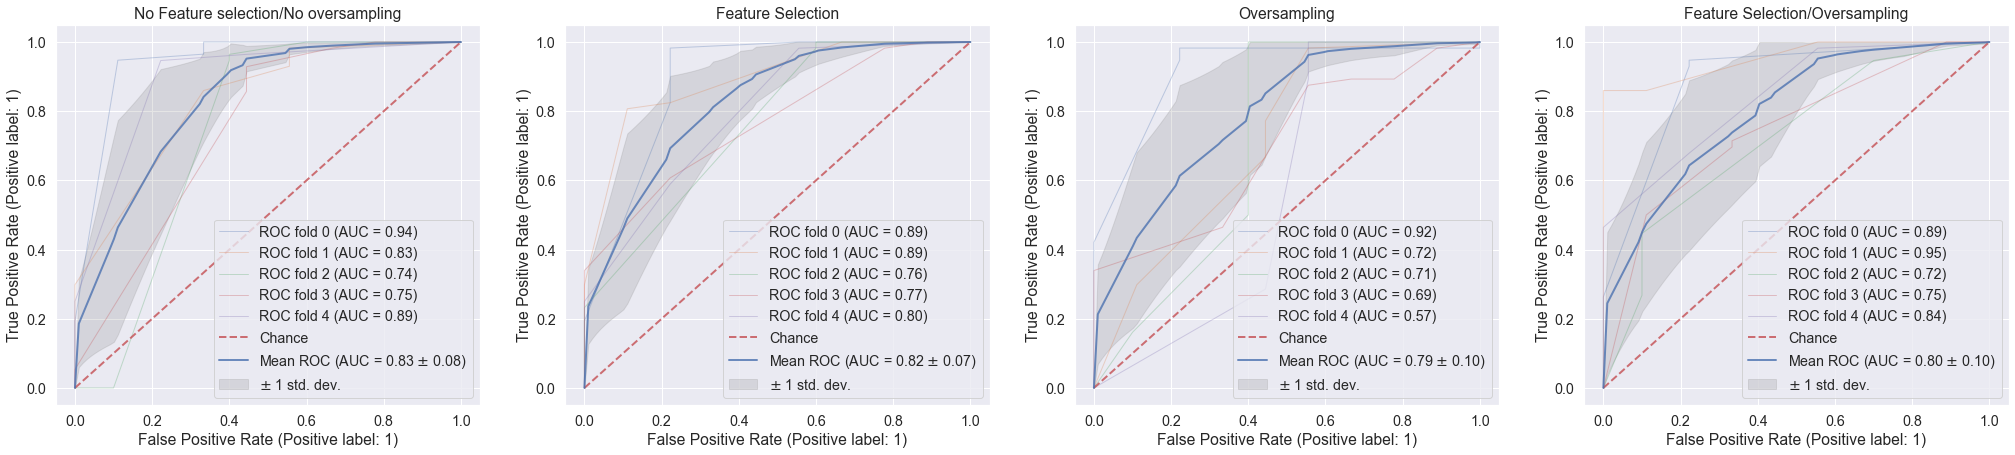

In [34]:
plotROC([dt, dt_fs, dt_os, dt_fs_os], train_df, columns_to_drop, target_column, scaler=None)

# 0 é status=-1

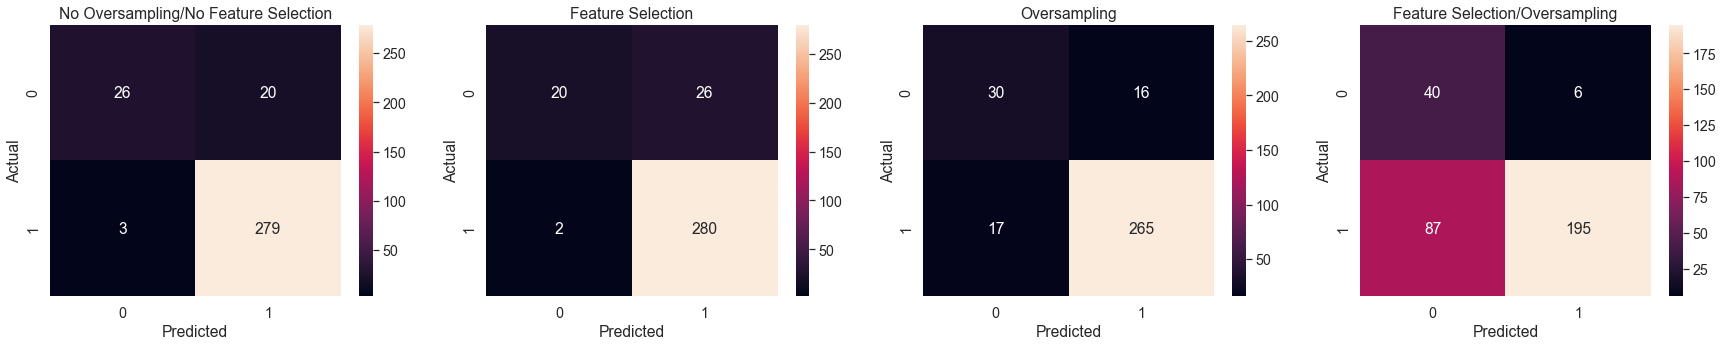

In [35]:
confMatrix([dt, dt_fs, dt_os, dt_fs_os], columns_to_drop, target_column, train_df)

### SVM
Needs to be scaled (StandardScaler)

In [36]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

parameter_grid = {
    'C': [1, 10, 50],
    'gamma': [0.001, 0.0001],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

svc, svc_fs, svc_os, svc_fs_os = (tune_model(
    train_df,
    SVC(probability=True, random_state=RANDOM_STATE),
    parameter_grid,
    columns_to_drop,
    target_column,
    scaler=StandardScaler(),
    oversample=oversample,
    feature_selection=feature_selection
) for oversample, feature_selection in ((False, False), (False, True), (True, False), (True, True)))


Best score: 0.8786988304093567
Best parameters: {'model__C': 50, 'model__gamma': 0.001, 'model__kernel': 'sigmoid'}
Best score: 0.866588693957115
Best parameters: {'model__C': 1, 'model__gamma': 0.001, 'model__kernel': 'linear'}
Best score: 0.8733764967975495
Best parameters: {'model__C': 50, 'model__gamma': 0.0001, 'model__kernel': 'sigmoid'}
Best score: 0.8729935950988581
Best parameters: {'model__C': 50, 'model__gamma': 0.0001, 'model__kernel': 'rbf'}


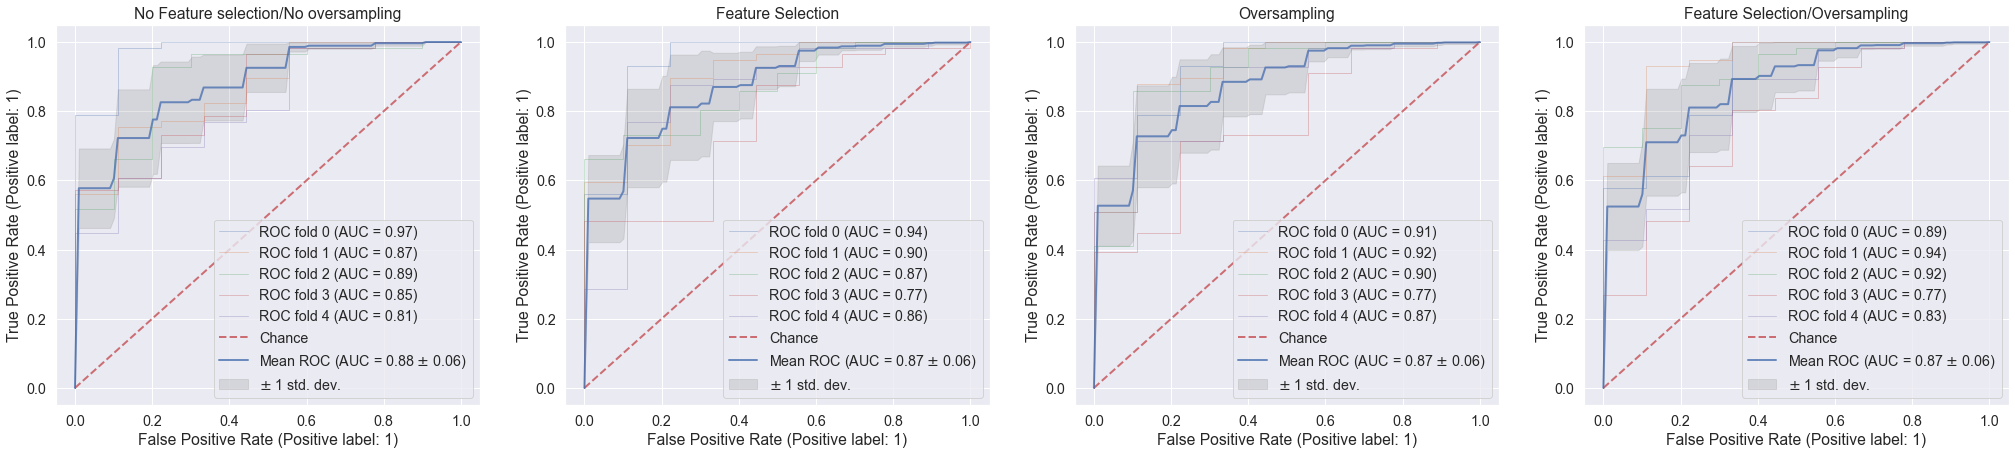

In [37]:
plotROC([svc, svc_fs, svc_os, svc_fs_os], train_df, columns_to_drop, target_column, scaler=StandardScaler())

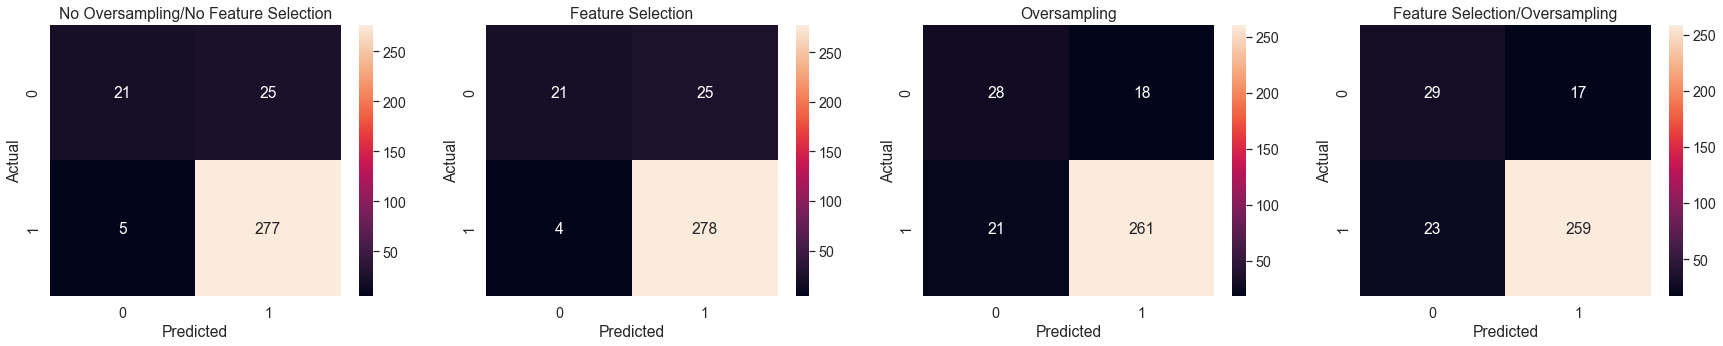

In [38]:
confMatrix([svc, svc_fs, svc_os, svc_fs_os], columns_to_drop, target_column, train_df, scaler=StandardScaler())

###  K-nearest neighbours (KNN)
Just like the SVM model, the KNN model also requires the data to be scaled.

In [39]:
from sklearn import neighbors

parameter_grid = {
    'n_neighbors': [4, 5, 6, 7, 10, 15],
    'leaf_size': [5, 10, 15, 20, 50, 100],
    'n_jobs': [-1],
    'algorithm': ['auto']
}

knn, knn_fs, knn_os, knn_fs_os = (tune_model(
    train_df, 
    neighbors.KNeighborsClassifier(), 
    parameter_grid, 
    columns_to_drop, 
    target_column, 
    scaler=StandardScaler(),
    oversample=oversample,
    feature_selection=feature_selection
) for oversample, feature_selection in ((False, False), (False, True), (True, False), (True,True)))

Best score: 0.8435515873015873
Best parameters: {'model__algorithm': 'auto', 'model__leaf_size': 5, 'model__n_jobs': -1, 'model__n_neighbors': 15}
Best score: 0.8550964216095794
Best parameters: {'model__algorithm': 'auto', 'model__leaf_size': 5, 'model__n_jobs': -1, 'model__n_neighbors': 5}
Best score: 0.8685199108883319
Best parameters: {'model__algorithm': 'auto', 'model__leaf_size': 5, 'model__n_jobs': -1, 'model__n_neighbors': 15}
Best score: 0.8778498329156224
Best parameters: {'model__algorithm': 'auto', 'model__leaf_size': 15, 'model__n_jobs': -1, 'model__n_neighbors': 5}


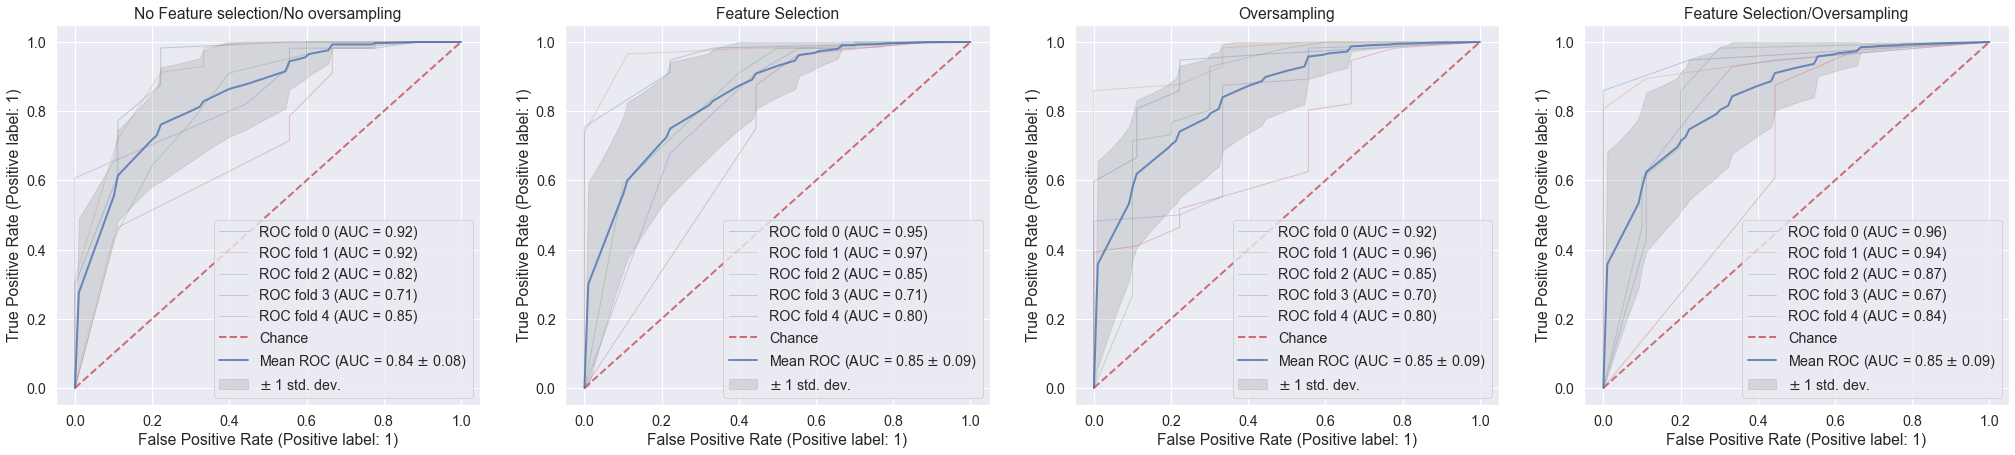

In [40]:
plotROC([knn, knn_fs, knn_os, knn_fs_os], train_df, columns_to_drop, target_column, scaler=StandardScaler())

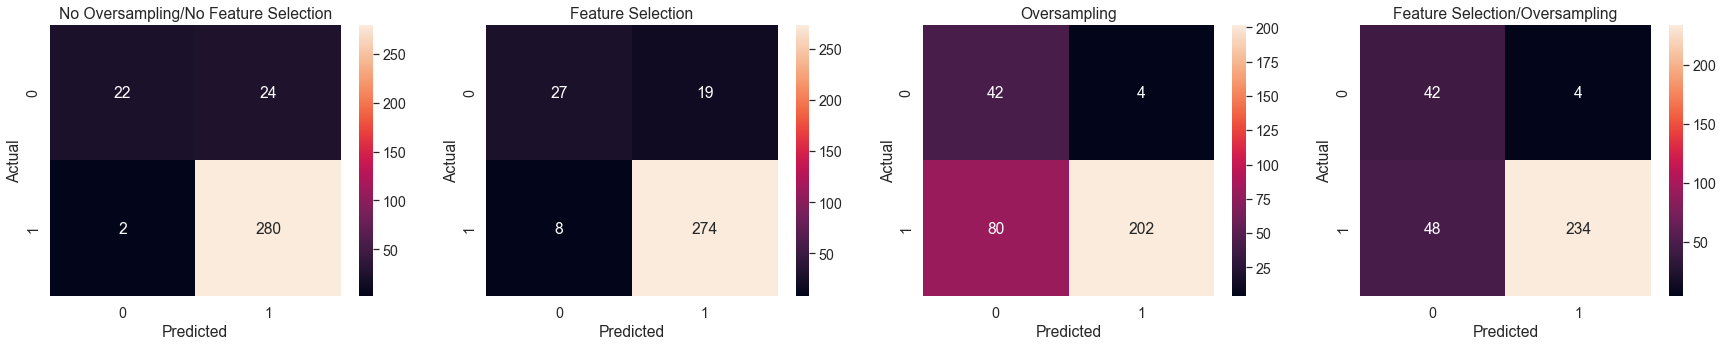

In [41]:
confMatrix([knn, knn_fs, knn_os, knn_fs_os], columns_to_drop, target_column, train_df, scaler=StandardScaler())

### Naïve Bayes

In [42]:
from sklearn.naive_bayes import GaussianNB

parameter_grid = {}

nb, nb_fs, nb_os, nb_fs_os = (tune_model(
    train_df, 
    GaussianNB(),
    parameter_grid, 
    columns_to_drop, 
    target_column, 
    scaler=StandardScaler(),
    oversample=oversample,
    feature_selection=feature_selection
) for oversample, feature_selection in ((False, False), (False, True), (True, False), (True,True)))

Best score: 0.8742592592592594
Best parameters: {}
Best score: 0.8503696741854638
Best parameters: {}
Best score: 0.8553891673628515
Best parameters: {}
Best score: 0.8472250069618491
Best parameters: {}


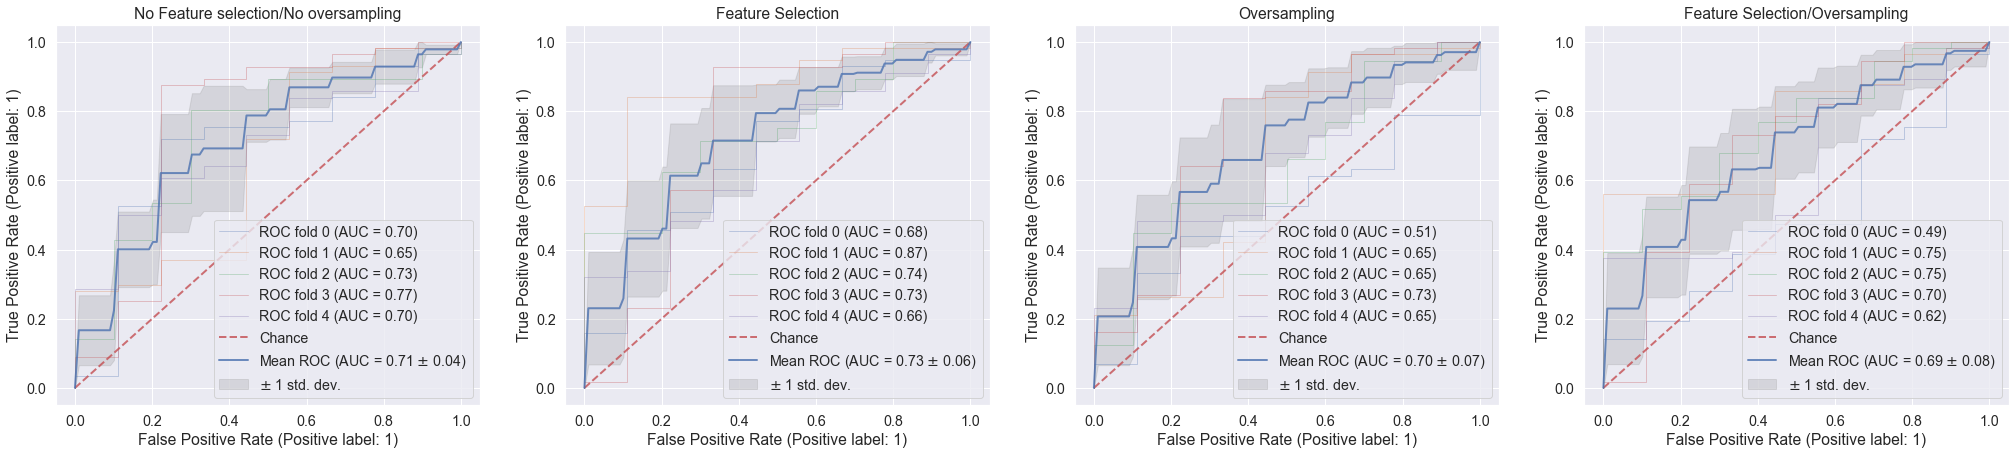

In [43]:
plotROC([nb, nb_fs, nb_os, nb_fs_os], train_df, columns_to_drop, target_column)

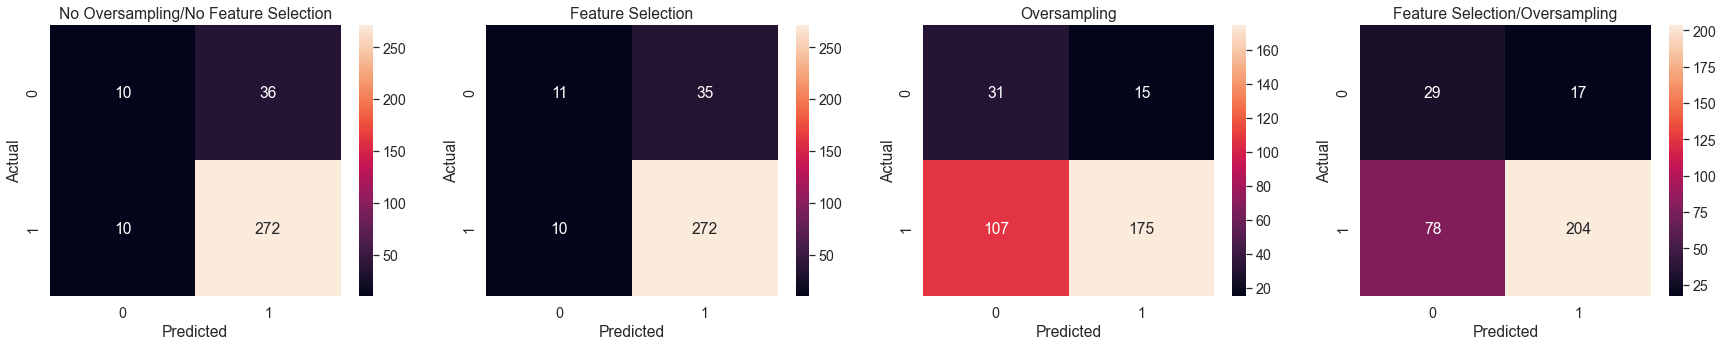

In [44]:
confMatrix([nb, nb_fs, nb_os, nb_fs_os], columns_to_drop, target_column, train_df)


In [45]:
# print(pd.DataFrame(nb.best_estimator_.steps[-1][1].feature_importances_, index=train_df.drop(columns_to_drop, axis=1).columns, columns=["Importance"]))


### Random Forest Classifier

In [46]:
from sklearn.ensemble import RandomForestClassifier

parameter_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [5, 10, 15],
    'n_jobs': [-1],  # Use all cores
    'criterion': ['gini', 'entropy']
}

rfc, rfc_fs, rfc_os, rfc_fs_os = (tune_model(
    train_df, 
    RandomForestClassifier(random_state=RANDOM_STATE), 
    parameter_grid, 
    columns_to_drop, 
    target_column,
    oversample=oversample,
    feature_selection=feature_selection
) for oversample, feature_selection in ((False, False), (False, True), (True, False), (True,True)))

Best score: 0.8811319966583125
Best parameters: {'model__criterion': 'entropy', 'model__max_depth': 5, 'model__n_estimators': 100, 'model__n_jobs': -1}
Best score: 0.8767369813422444
Best parameters: {'model__criterion': 'entropy', 'model__max_depth': 10, 'model__n_estimators': 50, 'model__n_jobs': -1}
Best score: 0.9032442216652743
Best parameters: {'model__criterion': 'entropy', 'model__max_depth': 10, 'model__n_estimators': 50, 'model__n_jobs': -1}
Best score: 0.8830576441102757
Best parameters: {'model__criterion': 'entropy', 'model__max_depth': 5, 'model__n_estimators': 100, 'model__n_jobs': -1}


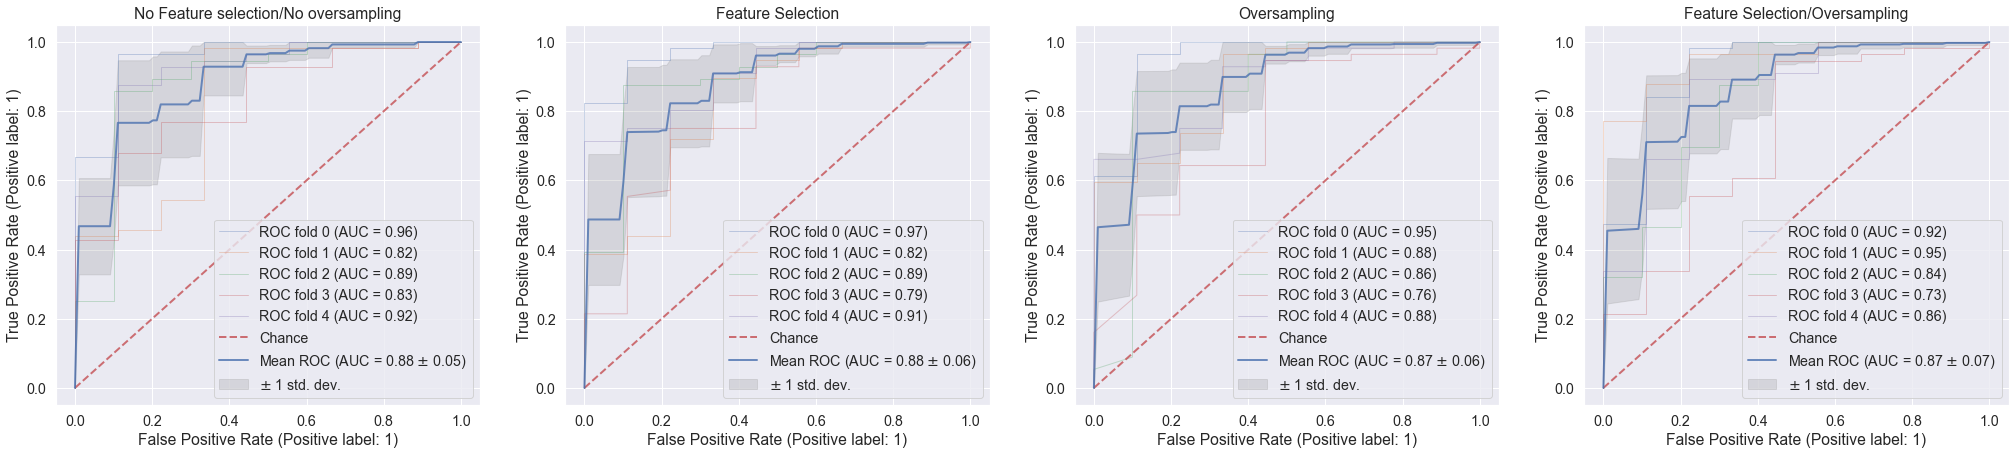

In [47]:
plotROC([rfc, rfc_fs, rfc_os, rfc_fs_os], train_df, columns_to_drop, target_column, scaler=None)

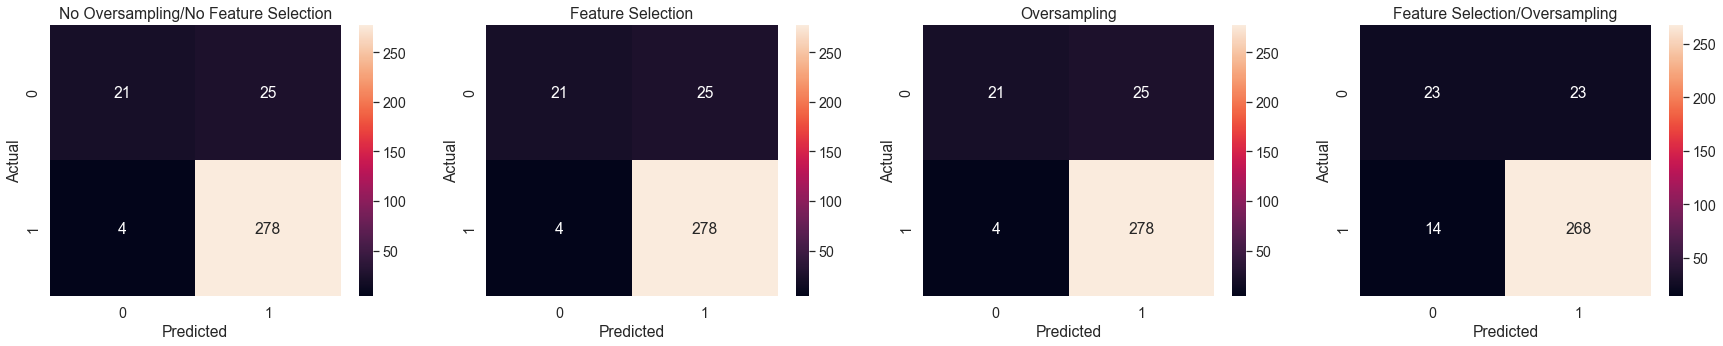

In [48]:
confMatrix([rfc, rfc_fs, rfc_os, rfc_fs_os], columns_to_drop, target_column, train_df, scaler=StandardScaler())


In [49]:
print(pd.DataFrame(rfc.best_estimator_.steps[-1][1].feature_importances_, index=train_df.drop(columns_to_drop, axis=1).columns, columns=["Importance"]))
# print(pd.DataFrame(rfc_fs.best_estimator_.steps[1][1].feature_importances_, index=train_df.drop(columns_to_drop, axis=1).columns, columns=["Importance"]))
# print(pd.DataFrame(rfc_fs.best_estimator_.steps[1][1].feature_importances_, index=train_df.drop(columns_to_drop, axis=1).columns[rfc_fs.best_estimator_.steps[0][1].get_feature_names_out()], columns=["Importance"]))
# rfc_fs.best_estimator_.steps[0][1].get_feature_names_out()

                                              Importance
loan_amount                                     0.055066
payments                                        0.093674
issuance_frequency_per_month                    0.013387
no. of municipalities with inhabitants < 499    0.035284
no. of cities                                   0.028342
region_woe                                      0.026091
balance_mean                                    0.103497
balance_min                                     0.132267
client_count_mean                               0.066157
operation_count                                 0.056948
type_transaction_count_withdrawal               0.076585
balance_dropped_below_zero                      0.194748
account_age                                     0.065290
days_since_last_transaction                     0.052664


## Logistic Regression

In [50]:
from sklearn.linear_model import LogisticRegression

parameter_grid = {
    "max_iter": [1000, 5000, 10000],
    "solver": ["lbfgs"]
}

lr, lr_fs, lr_os, lr_fs_os = (tune_model(
    train_df,
    LogisticRegression(class_weight="balanced", random_state=RANDOM_STATE),
    parameter_grid,
    columns_to_drop,
    target_column,
    scaler=StandardScaler(),
    oversample=oversample,
    feature_selection=feature_selection
) for oversample, feature_selection in ((False, False), (False, True), (True, False), (True,True)))

Best score: 0.8604727095516569
Best parameters: {'model__max_iter': 1000, 'model__solver': 'lbfgs'}
Best score: 0.8685032024505709
Best parameters: {'model__max_iter': 1000, 'model__solver': 'lbfgs'}
Best score: 0.8670551378446115
Best parameters: {'model__max_iter': 1000, 'model__solver': 'lbfgs'}
Best score: 0.877041910331384
Best parameters: {'model__max_iter': 10000, 'model__solver': 'lbfgs'}


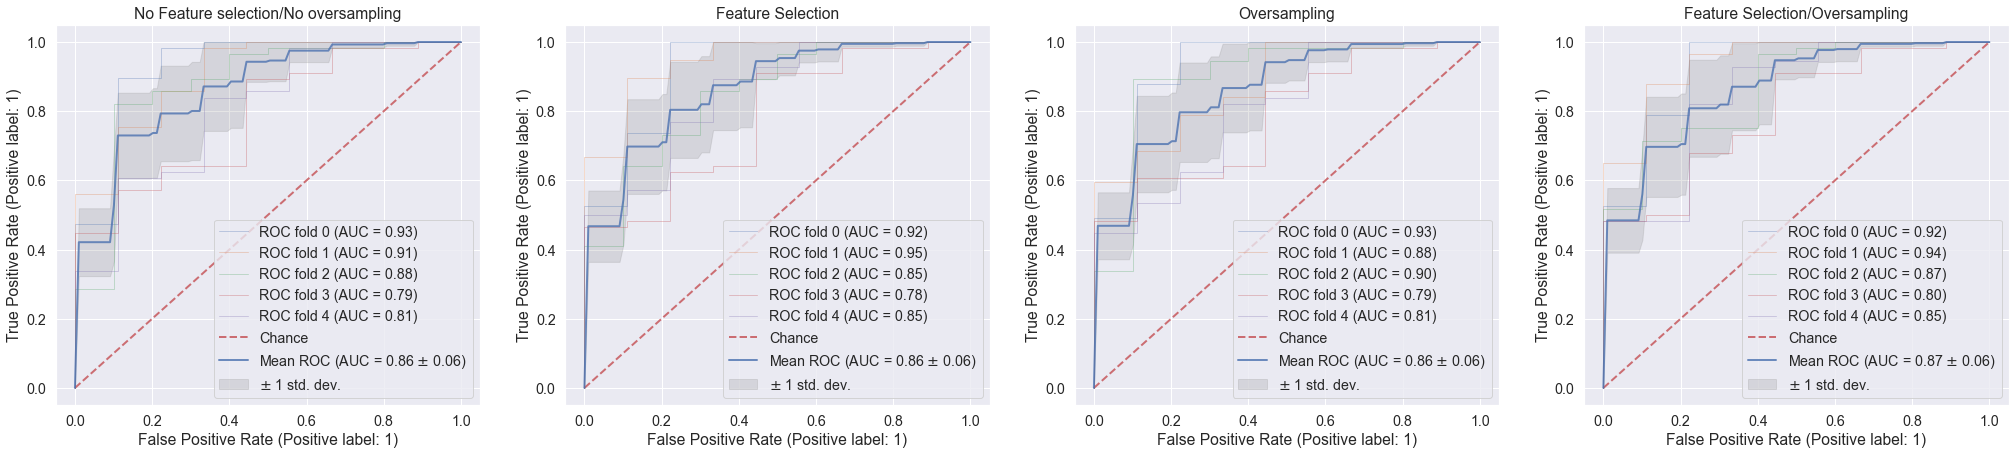

In [51]:
plotROC([lr, lr_fs, lr_os, lr_fs_os], train_df, columns_to_drop, target_column, scaler=StandardScaler())

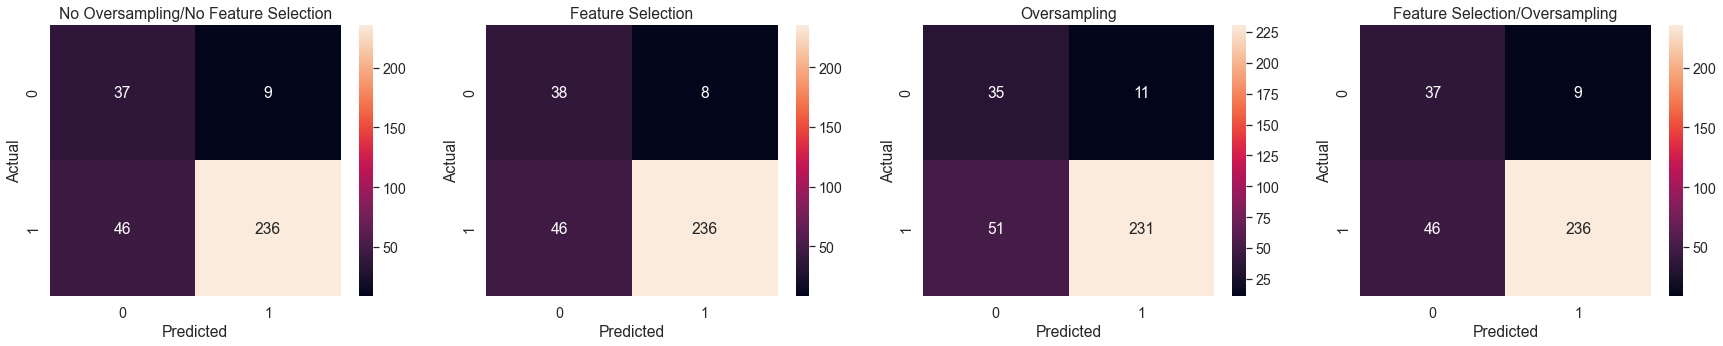

In [52]:
confMatrix([lr, lr_fs, lr_os, lr_fs_os], columns_to_drop, target_column, train_df, scaler=StandardScaler())

## Comparing Models

''

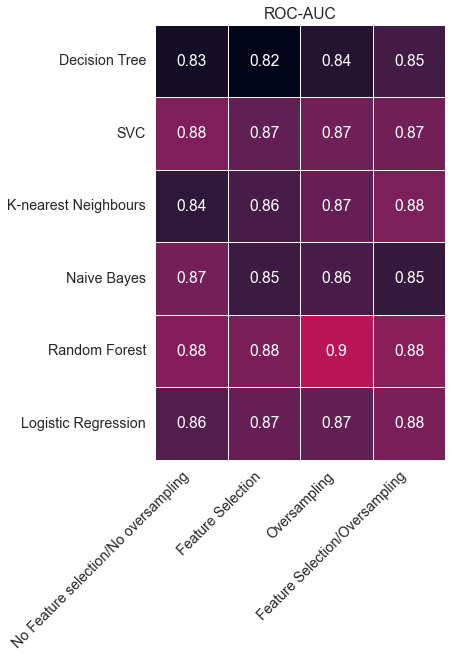

In [53]:
import seaborn as sb

scores = {
    "Decision Tree": [dt, dt_fs, dt_os, dt_fs_os],
    "SVC": [svc, svc_fs, svc_os, svc_fs_os],
    "K-nearest Neighbours": [knn, knn_fs, knn_os, knn_fs_os],
    "Naive Bayes": [nb, nb_fs, nb_os, nb_fs_os],
    "Random Forest": [rfc, rfc_fs, rfc_os, rfc_fs_os],
    "Logistic Regression": [lr, lr_fs, lr_os, lr_fs_os]
}

x_axis_labels = ["No Feature selection/No oversampling",
                 "Feature Selection", "Oversampling", "Feature Selection/Oversampling"]
y_axis_labels = scores.keys()

plt.figure(figsize=(10, 8))

scores_array = np.array([[model.best_score_ for model in models]
                         for models in scores.values()])

sb.set(font_scale=1.3)
sb.heatmap(scores_array, annot=True, linewidths=0.5, vmax=1,
           square=True, xticklabels=x_axis_labels, yticklabels=y_axis_labels, cbar=False)
plt.title("ROC-AUC")

plt.xticks(rotation=45, horizontalalignment='right')
;

(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0.5, 0, 'No Feature selection/No oversampling'),
  Text(1.5, 0, 'Feature Selection'),
  Text(2.5, 0, 'Oversampling'),
  Text(3.5, 0, 'Feature Selection/Oversampling')])

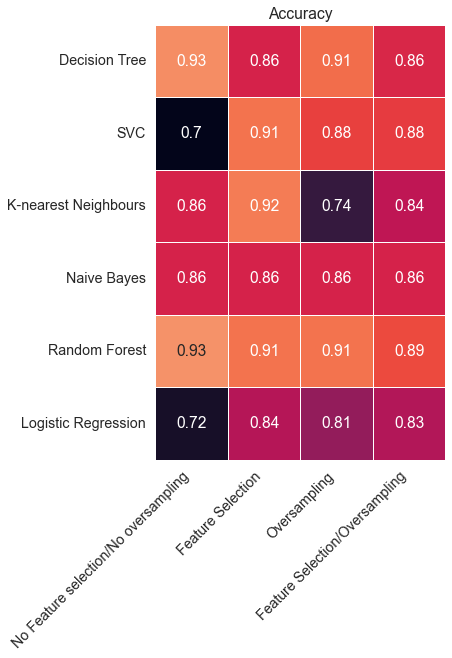

In [54]:

from sklearn.metrics import f1_score, accuracy_score

scores = {
    "Decision Tree": [dt, dt_fs, dt_os, dt_fs_os],
    "SVC": [svc, svc_fs, svc_os, svc_fs_os],
    "K-nearest Neighbours": [knn, knn_fs, knn_os, knn_fs_os],
    "Naive Bayes": [nb, nb_fs, nb_os, nb_fs_os],
    "Random Forest": [rfc, rfc_fs, rfc_os, rfc_fs_os],
    "Logistic Regression": [lr, lr_fs, lr_os, lr_fs_os]
}

x_axis_labels = ["No Feature selection/No oversampling",
                 "Feature Selection", "Oversampling", "Feature Selection/Oversampling"]
y_axis_labels = scores.keys()

plt.figure(figsize=(10, 8))

scale = [None, StandardScaler(), StandardScaler(), StandardScaler(), None, StandardScaler()]

scores_array = np.array([[accuracy_score(get_X_y(train_df, columns_to_drop, target_column, scaler=scale[i])[1], 
                            models[i].best_estimator_.predict(get_X_y(train_df, columns_to_drop, target_column, scaler=scale[i])[0])) for i in range(len(models))]
                         for models in scores.values()])

sb.set(font_scale=1.3)
sb.heatmap(scores_array, annot=True, linewidths=0.5, vmax=1,
           square=True, xticklabels=x_axis_labels, yticklabels=y_axis_labels, cbar=False)
plt.title("Accuracy")

plt.xticks(rotation=45, horizontalalignment='right')


(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0.5, 0, 'No Feature selection/No oversampling'),
  Text(1.5, 0, 'Feature Selection'),
  Text(2.5, 0, 'Oversampling'),
  Text(3.5, 0, 'Feature Selection/Oversampling')])

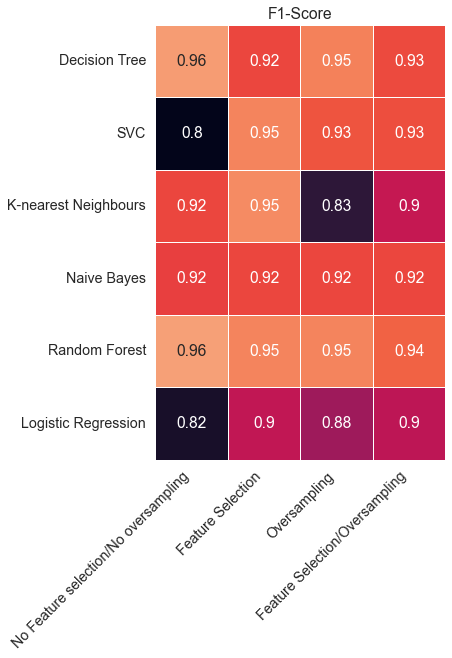

In [55]:

from sklearn.metrics import f1_score

scores = {
    "Decision Tree": [dt, dt_fs, dt_os, dt_fs_os],
    "SVC": [svc, svc_fs, svc_os, svc_fs_os],
    "K-nearest Neighbours": [knn, knn_fs, knn_os, knn_fs_os],
    "Naive Bayes": [nb, nb_fs, nb_os, nb_fs_os],
    "Random Forest": [rfc, rfc_fs, rfc_os, rfc_fs_os],
    "Logistic Regression": [lr, lr_fs, lr_os, lr_fs_os]
}

x_axis_labels = ["No Feature selection/No oversampling",
                 "Feature Selection", "Oversampling", "Feature Selection/Oversampling"]
y_axis_labels = scores.keys()

plt.figure(figsize=(10, 8))

scale = [None, StandardScaler(), StandardScaler(), StandardScaler(), None, StandardScaler()]

scores_array = np.array([[f1_score(get_X_y(train_df, columns_to_drop, target_column, scaler=scale[i])[1], 
                            models[i].best_estimator_.predict(get_X_y(train_df, columns_to_drop, target_column, scaler=scale[i])[0])) for i in range(len(models))]
                         for models in scores.values()])

sb.set(font_scale=1.3)
sb.heatmap(scores_array, annot=True, linewidths=0.5, vmax=1,
           square=True, xticklabels=x_axis_labels, yticklabels=y_axis_labels, cbar=False)
plt.title("F1-Score")

plt.xticks(rotation=45, horizontalalignment='right')

## ROC curves

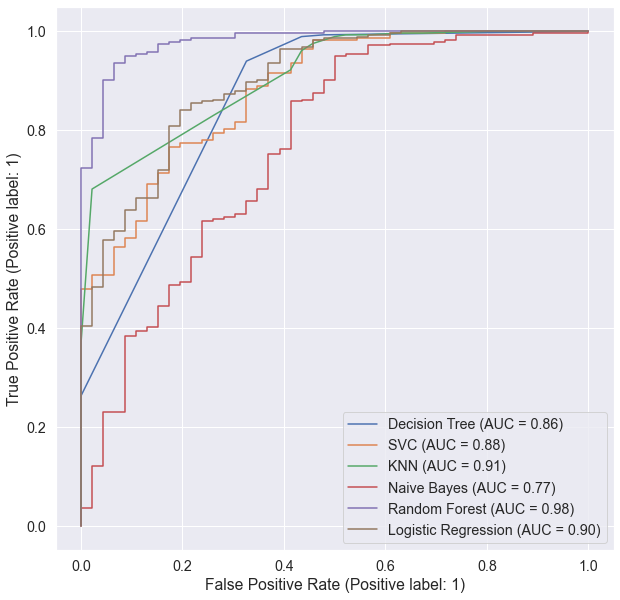

In [56]:
scalers = [False, True, True, True, False, True]

plotAlgorithmROC([dt, svc, knn, nb, rfc, lr],
                 ["Decision Tree", "SVC", "KNN", "Naive Bayes", "Random Forest", "Logistic Regression"],
                 train_df,
                 columns_to_drop,
                 target_column,
                 scalers=scalers)


### Feature Selection

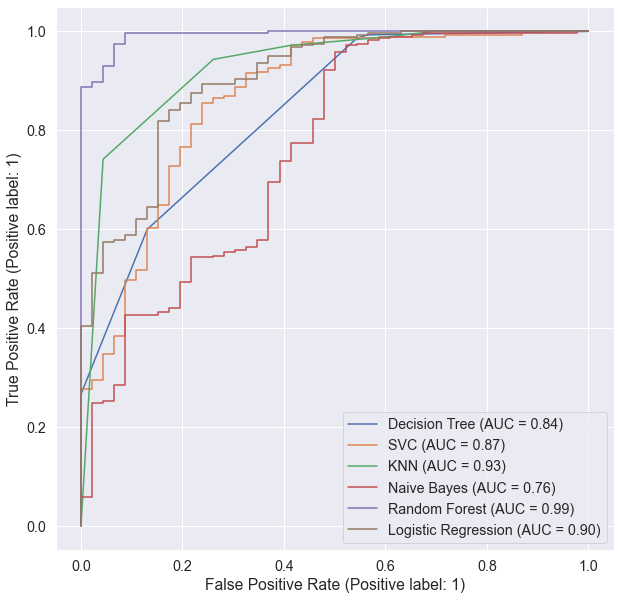

In [57]:
plotAlgorithmROC([dt_fs, svc_fs, knn_fs, nb_fs, rfc_fs, lr_fs],
                 ["Decision Tree", "SVC", "KNN", "Naive Bayes", "Random Forest", "Logistic Regression"],
                 train_df,
                 columns_to_drop,
                 target_column,
                 scalers=scalers)

### Oversampling

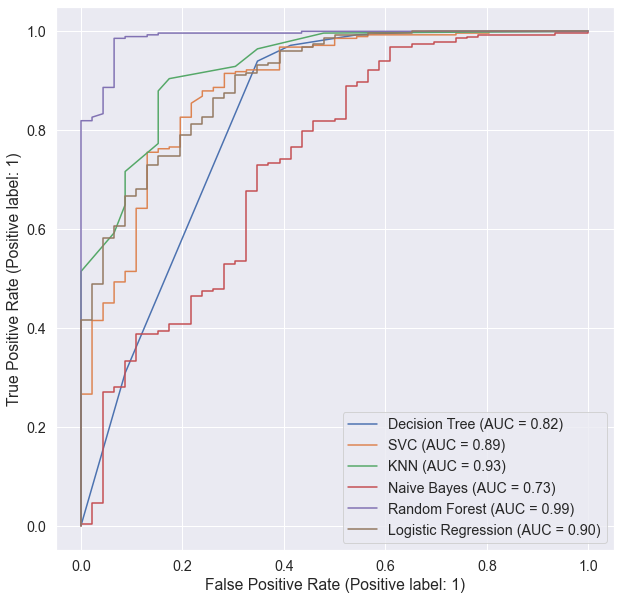

In [58]:
plotAlgorithmROC([dt_os, svc_os, knn_os, nb_os, rfc_os, lr_os],
                 ["Decision Tree", "SVC", "KNN", "Naive Bayes", "Random Forest", "Logistic Regression"],
                 train_df,
                 columns_to_drop,
                 target_column,
                 scalers=scalers)

### Feature Selection / Oversampling

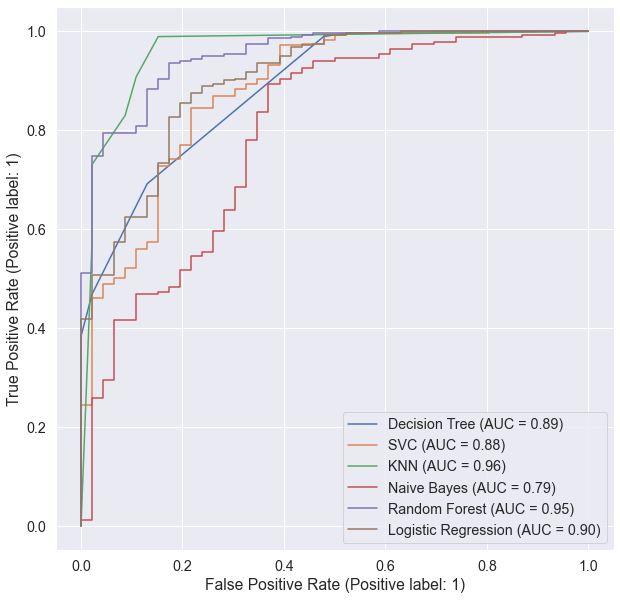

In [59]:
plotAlgorithmROC([dt_fs_os, svc_fs_os, knn_fs_os, nb_fs_os, rfc_fs_os, lr_fs_os],
                 ["Decision Tree", "SVC", "KNN", "Naive Bayes", "Random Forest", "Logistic Regression"],
                 train_df,
                 columns_to_drop,
                 target_column,
                 scalers=scalers)

## Save results

In [60]:
X_result = test_df.drop(columns_to_drop, axis=1)

y_result = dt_fs_os.predict_proba(X_result)[:, 0]

result = pd.DataFrame({"Id": test_df["loan_id"], "Predicted": y_result})
result.drop_duplicates(inplace=True)
result.to_csv("../out/result.csv", index=False)